In [1]:
# Import libraries
!pip install mne --quiet

import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import urllib.request

# Select a EDF file
subject_id = 1
task_id = 8  # Motor imagery events (e.g., left/right hand)

filename = f"S{subject_id:03d}R{task_id:02d}.edf"

# Download the file if it doesn't exist
if not os.path.exists(filename):
    print(f"Downloading {filename}...")
    base_url = f"https://physionet.org/static/published-projects/eegmmidb/1.0.0/S{subject_id:03d}/{filename}"
    urllib.request.urlretrieve(base_url, filename)
    print(f"{filename} downloaded.")
else:
    print(f"{filename} already exists.")

# Load the EDF file
raw = mne.io.read_raw_edf(filename, preload=True, stim_channel='auto')

# Clean up channel names (remove trailing dots etc.)
raw.rename_channels(lambda x: x.strip('.'))

# Apply standard 10-20 montage and ignore channels not found
raw.set_montage('standard_1020', on_missing='ignore')

# Print basic data info
raw.info

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 37.5 MB/s eta 0:00:00
S001R08.edf downloaded.
Extracting EDF parameters from /content/S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


<Info | 9 non-empty values
 bads: []
 ch_names: Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 39 items (3 Cardinal, 36 EEG)
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>

Using matplotlib as 2D backend.


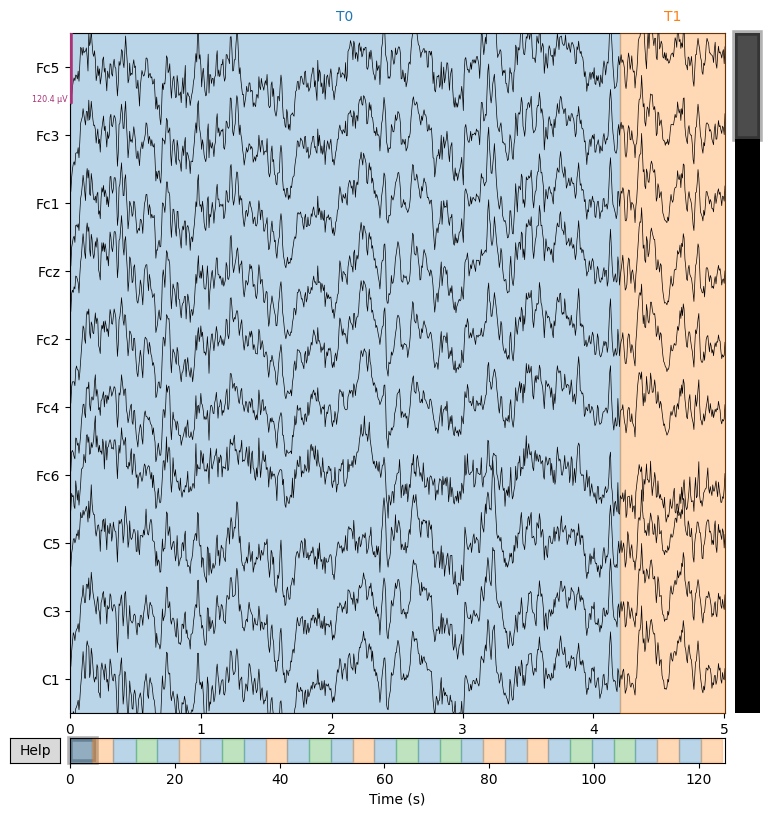

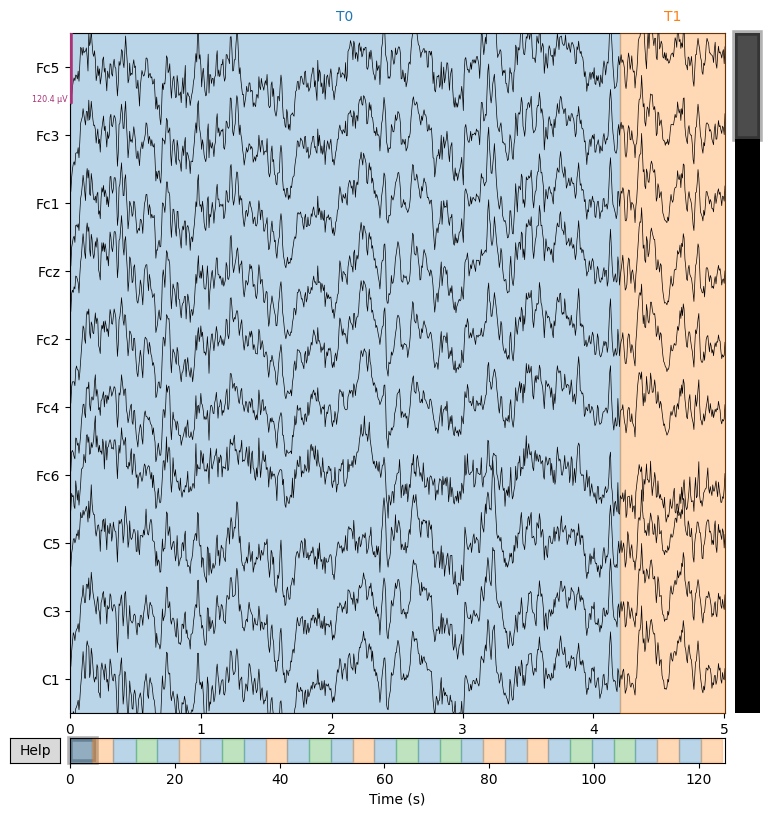

In [2]:
# Plot 10 EEG channels for visual inspection
raw.plot(n_channels=10, duration=5, scalings='auto')

In [3]:
# Band-pass FIR (finite impulse response) for 1 Hz and 40 Hz
raw_filtered = raw.copy().filter(1., 40., fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


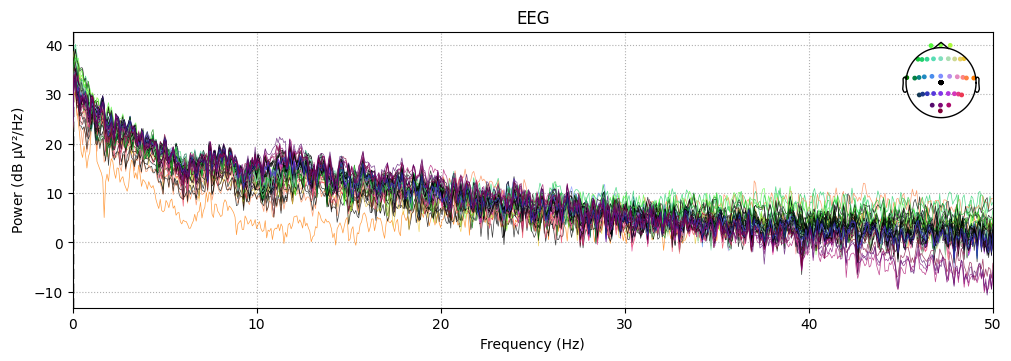

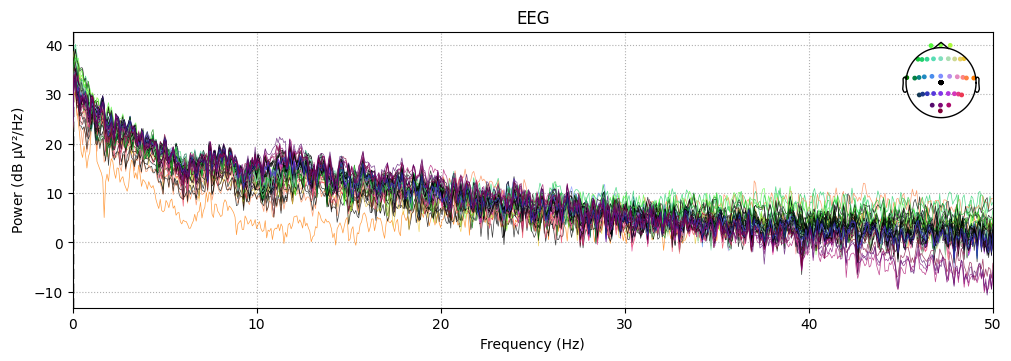

In [4]:
raw.compute_psd(fmax=50).plot()

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


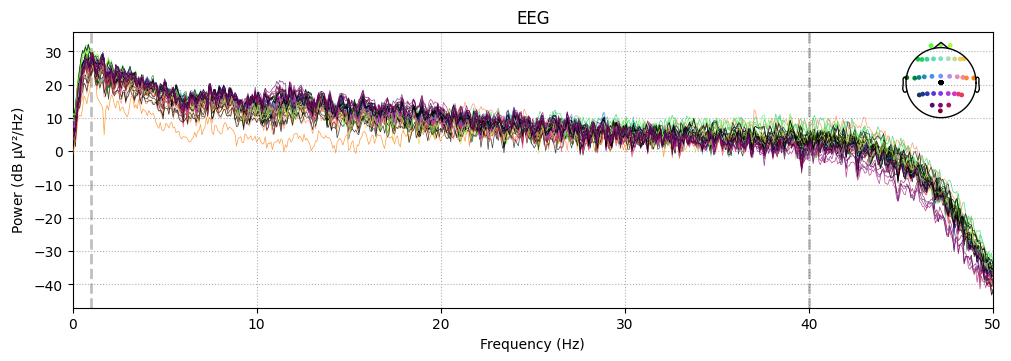

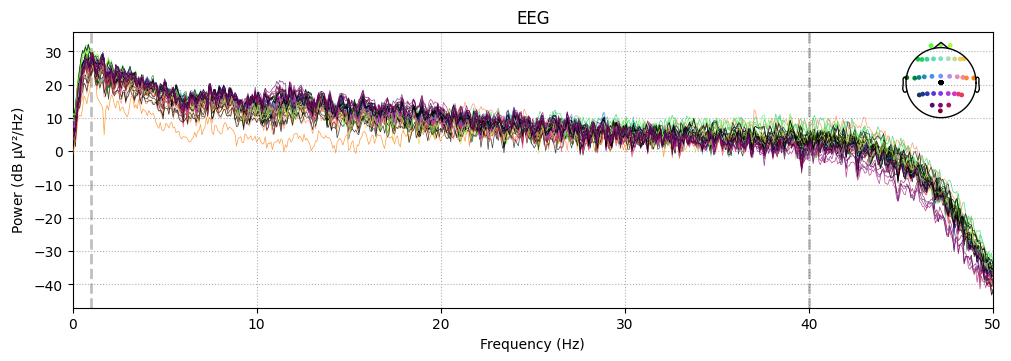

In [5]:
raw_filtered.compute_psd(fmax=50).plot()

Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Event IDs: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


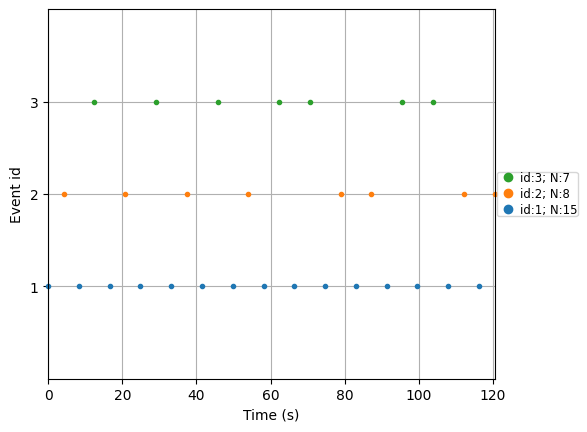

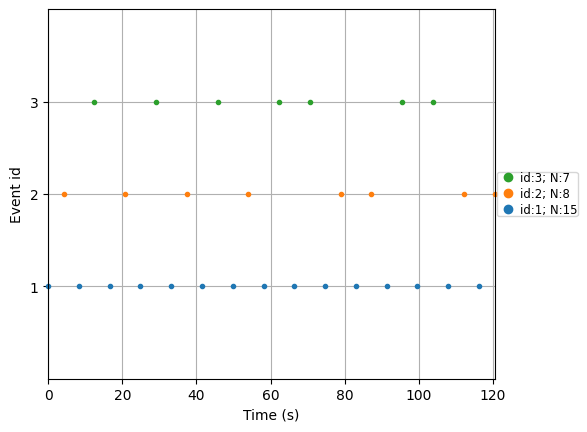

In [6]:
# Convert annotations to events
events, event_id = mne.events_from_annotations(raw)

# Show the mapping from annotation labels to integers
print("Event IDs:", event_id)
  # T0	Rest or no movement (baseline)
  # T1	Left-hand motor imagery
  # T2	Right-hand motor imagery
# Plot the events
mne.viz.plot_events(events, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)

In [7]:
# Define time window in seconds (e.g., 0s to 4s after event onset)
tmin, tmax = 0, 4

# Create epochs for T1 and T2 (left and right hand)
epochs = mne.Epochs(raw, events, event_id={'T1': 2, 'T2': 3},
                    tmin=tmin, tmax=tmax, baseline=None,
                    preload=True)

# Drop bad epochs (flat or noisy)
epochs.drop_bad()

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 641 original time points ...
0 bad epochs dropped


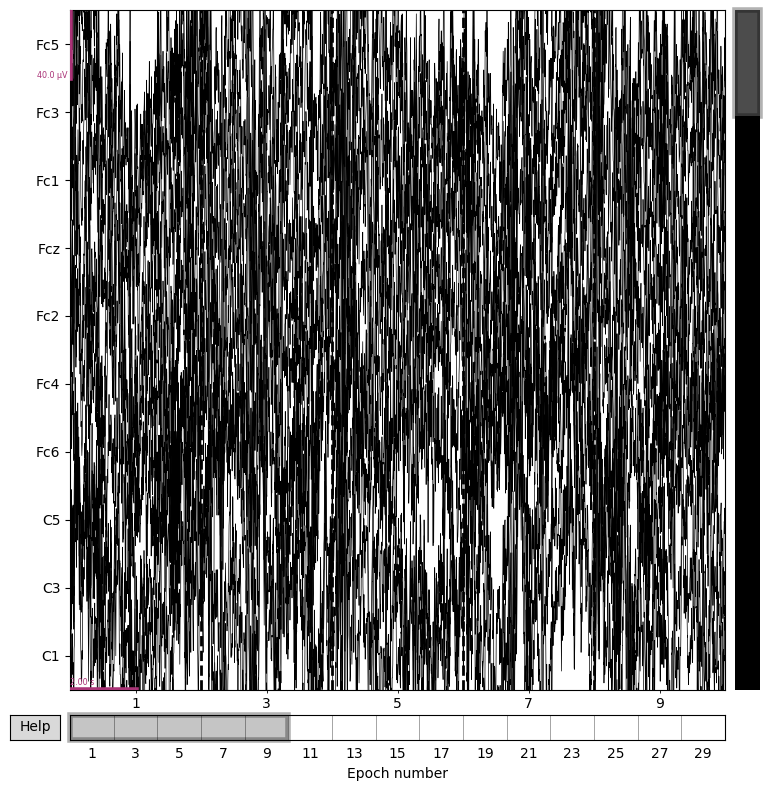

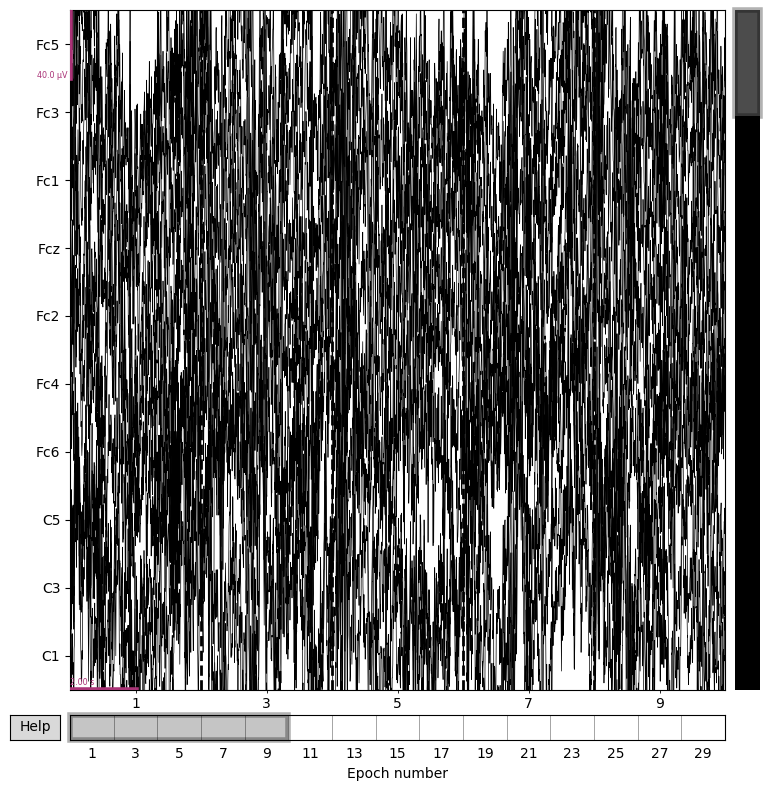

In [8]:
# Plot one epoch to see the signal
epochs.plot(n_epochs=5, n_channels=10)

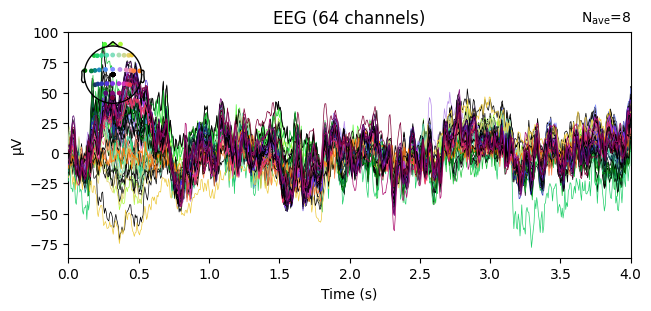

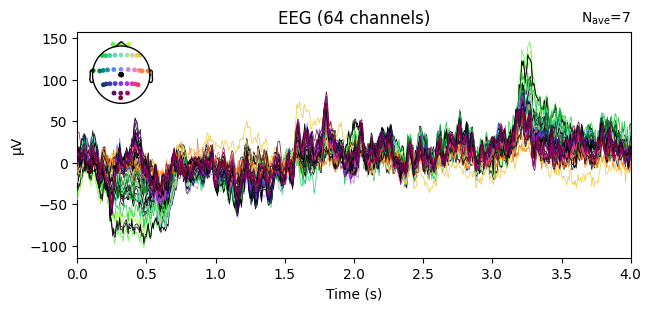

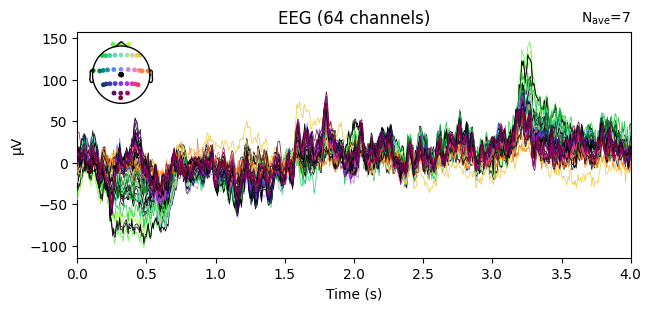

In [9]:
# Average signal (ERP)
evoked_left = epochs['T1'].average()
evoked_right = epochs['T2'].average()

# Plot ERP
evoked_left.plot()
evoked_right.plot()